In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve,least_squares,root

import sys, os
import pickle

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig
import multiprocessing as mp
from multiprocessing import set_start_method
#set_start_method("spawn")

from matplotlib.lines import Line2D

me.mechanics_printing()

In [2]:
# Create simplified model
fwt_panels = 10
main_panels = 20

p = RollRig.base_params(3, panels = fwt_panels*2 + main_panels)  
sm = mf.SymbolicModel.from_file('RollRigModel.py')

In [3]:
sm.ExtForces = ef.CompositeForce([sm.ExtForces,ef.CustomForce(None)])
sm = sm.subs({p.alpha_r.name:0,p.alpha_1.name:sym.atan(sym.sin(p.Lambda)*sym.tan(p.q[1])),
             p.alpha_2.name:sym.atan(sym.sin(p.Lambda)*sym.tan(p.q[2]))})
sm.to_file('tempModel_free.py')

In [4]:
# Add fixed params to dict
params = {}
params['c'] = 0.067
params['s'] = 1
params['g'] = 9.81
params['sigma'] = 0.272
params['alpha_r'] = 0
params['c_d_max'] = 1
params['m_w'] = 0.773
params['I_xx_w'] = 0.019480411
params['y_w'] = 0.00198
params['z_w'] = -0.00273
params['c_d_max'] = 0
params['T'] = 0.12

In [5]:
# create lift distribution
def create_lift_dist_from_file(filename,span,sigma,main_panels,fwt_panels):
    s_w = span*(1-sigma)
    delta = s_w / main_panels
    y_panel_main = np.linspace(-s_w/2+delta/2,s_w/2-delta/2,main_panels)

    s_f = span*sigma/2
    delta = s_f / fwt_panels
    y_panel_fwt = np.linspace(delta/2,s_f-delta/2,fwt_panels)+s_w/2
    y_panel = [*-np.flip(y_panel_fwt),*y_panel_main,*y_panel_fwt]

    ## load lift distribution
    df = pd.read_csv(filename)
    y_span = df['y'].to_numpy()
    y_c_l = df['C_l'].to_numpy()

    # interpolate on each panel
    return list(np.interp(np.abs(y_panel),y_span,y_c_l,left=0,right=0))

def create_const_lift_dist(main_panels,fwt_panels):
    return [np.pi*2]*(main_panels+(2*fwt_panels))

def create_tapered_lift_dist(main_panels,fwt_panels):
    val = 2*np.pi
    main_a = [val]*main_panels
    fwt_a = [((i+0.5)/fwt_panels)*val for i in range(fwt_panels)]
    return [*fwt_a,*main_a,*reversed(fwt_a)]

In [6]:
# Calculate Lift Distributions
lift_dists=[]
tmp_params = {}
tmp_params['p'] = 1
tmp_params['a'] = create_lift_dist_from_file(r'LiftDistribution_aoa_0_rr_60_span_100.csv',params['s'],params['sigma'],main_panels,fwt_panels)
lift_dists.append(({'LiftDist':'Roll60'},tmp_params.copy()))

tmp_params = {}
tmp_params['p'] = 1
tmp_params['a'] = create_lift_dist_from_file(r'LiftDistribution_aoa_5_rr_0_span_100.csv',params['s'],params['sigma'],main_panels,fwt_panels)
lift_dists.append(({'LiftDist':'AoA5'},tmp_params.copy()))

tmp_params = {}
tmp_params['p'] = 1
tmp_params['a'] = create_lift_dist_from_file(r'LiftDistribution_auto_rotate_fwt_angle_2.csv',params['s'],params['sigma'],main_panels,fwt_panels)

lift_dists.append(({'LiftDist':'Level'},tmp_params.copy()))

In [7]:
# create configs
configs = []
tmp_params = {}
tmp_params['Lambda'] = np.deg2rad(10)
tmp_params['alpha_c'] = np.deg2rad(0)
tmp_params['l_f'] = 0.0766*np.cos(tmp_params['Lambda'])
tmp_params['I_xx_f'] = 8.85e-5
tmp_params['m_f'] = 0.05
configs.append(({'Mode':'Free'},tmp_params.copy()))

tmp_params = {}
tmp_params['Lambda'] = np.deg2rad(30)
tmp_params['alpha_c'] = np.deg2rad(0)
tmp_params['l_f'] = 0.0766*np.cos(tmp_params['Lambda'])
tmp_params['I_xx_f'] = 8.68e-5
tmp_params['m_f'] = 0.05
configs.append(({'Mode':'Free'},tmp_params.copy()))

In [8]:
# create Jobs
attitudes=[]


velocity = np.linspace(15,30,7)
for v in velocity:
    attitudes.append(({},{"V":v,"beta":0}))

In [9]:
jobs=[({**config,**att,**lift_dist},{**params,**config_params,**att_params,**lift_dist_params}) for config,config_params in configs for att,att_params in attitudes for lift_dist,lift_dist_params in lift_dists]

In [10]:
def calc_coast_angle(filename, qs, ic, params,panels=20, additional_cols={}):   
    # Set the parameters
    p = RollRig.base_params(qs,panels = 40)
    p_vars = vars(p)
    for string, value in params.items():
        if string in p_vars:
            p_vars[string].value = value
    # Load the Model 
    sm = mf.SymbolicModel.from_file(filename)
    sm.ExtForces = ef.CompositeForce([sm.ExtForces, ef.CustomForce(None)])
             
    # Create Numeric Model
    nm = mf.NumericModel.from_SymbolicModel(p, sm)
    
    try:
        ic = RollRig.Calc_coast(nm,p,ic)
        tup = p.GetNumericTuple(ic, 0)       
        forces = -nm.f_func(tup,ic)+nm.ExtForces(tup,ic,0)
        torq = forces[0][0]
    except:
        torq = np.nan
        ic[2] = np.nan
        ic[4] = np.nan

    # return result
    result = []
    result.append({"Torque":torq,"Side":"Left",
                "CoastAngle":np.rad2deg(ic[2]),
                **params, **additional_cols })
    result.append({"Torque":torq,"Side":"Right",
                "CoastAngle":np.rad2deg(ic[4]),
                **params, **additional_cols})
    return result

In [11]:
job = jobs[1]
ic = [0]*6
res=[]
for job in jobs:
    tmp_res = calc_coast_angle('tempModel_free.py',3,ic,params=job[1],
                                     panels=main_panels + 2*fwt_panels,
                                     additional_cols={**job[0]})
    res.extend(tmp_res)

NameError: name 'df' is not defined

In [12]:
df = pd.DataFrame(res)

In [15]:
# %%time
# # for each job edit the parameters and pool it 
# pool = mp.Pool(mp.cpu_count())
# ic = [0]*6
# res=[]
# for job in jobs:
#     res.append(pool.apply_async(calc_coast_angle, args = ('tempModel_free.py',3,ic,job[1],main_panels + 2*fwt_panels,{**job[0]})))
# pool.close()
# pool.join()

# ls = []
# for i in res:
#     ls += i.get()
# df = pd.DataFrame(ls)

In [13]:
df['Flare'] = pd.Categorical(np.round(np.rad2deg(df['Lambda'])))
df['Camber']=np.rad2deg(df['alpha_c'])
df.to_csv(r'/Users/fintan/Git/FlexiFWT_DAQ/Analysis/RollingRigV3/ModelComparisonV2/CoastData_level_sintan.csv', index = False)

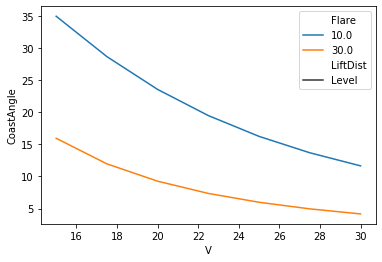

In [14]:
sns.lineplot(data=df[(df['Side']=='Left') & (df['LiftDist']=='Level')],x='V',y='CoastAngle',style="LiftDist",hue='Flare')